# Introduction
<hr style="border:2px solid black"> </hr>

In [ ]:
"""
What? Tuning stochastic gradient boosting

A simple technique for ensembling decision trees involves training trees on subsamples 
of the training dataset. Subsets of the rows in the training data can be taken to train
individual trees called BAGGING. When subsets of rows of the training data are also 
taken when calculating each split point, this is called RANDOM FOREST. 

These techniques can also be used in the gradient tree boosting model in a technique 
called stochastic gradient boosting.

https://xgboost.readthedocs.io/en/latest/parameter.html
"""

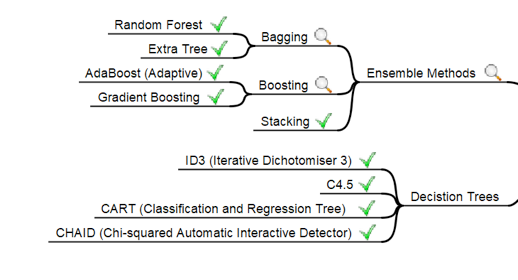

# Import python modules

In [1]:
import matplotlib
from matplotlib import pyplot
from pylab import rcParams
from pandas import read_csv
from xgboost import XGBClassifier
from IPython.display import Markdown, display
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Loading the dataset

In [16]:
# load data
data = read_csv('../DATASETS/train_Otto_classification.csv')
dataset = data.values
# split data into X and y
X = dataset[:,0:94]
y = dataset[:,94]

print("Input X shape: ", X.shape)
print("Label y shape: ", y.shape)
print("y type ", type(y))

Input X shape:  (61878, 94)
Label y shape:  (61878,)
y type  <class 'numpy.ndarray'>


# Encode string class values as integers

In [ ]:
"""
Computer will not understanfd string hence we use encoding to turn string into digit.
In fact most ML algorithm cannot handle text data directly.
"""

In [12]:
print("Label before encoding", y[:5])
label_encoded_y = LabelEncoder().fit_transform(y)
print("Label after encoding", label_encoded_y[:5])
print("Label yEncoded shape: ", y.shape)

Label before encoding ['Class_1' 'Class_1' 'Class_1' 'Class_1' 'Class_1']
Label after encoding [0 0 0 0 0]
Label yEncoded shape:  (61878,)


### Tuning row subsampling

In [ ]:
"""
Row subsampling involves selecting a random sample of the training dataset without 
replacement. 

subsample ratio [default=1, range: (0,1], of the training instances. Setting it to 0.5 means that XGBoost
would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. 
Subsampling will occur once in every boosting iteration.

Row subsampling can be specified in the scikit-learn wrapper of the 
XGBoost class in the subsample parameter. The default is 1.0 which is no sub-sampling.
We can use the grid search capability built into scikit-learn to evaluate the effect 
of different subsample values from 0.1 to 1.0

XGBoost API: https://xgboost.readthedocs.io/en/latest/parameter.html
"""

In [ ]:
# grid search
model = XGBClassifier()
subsample = [0.1, 0.3, 0.5, 0.7, 1.0]
param_grid = dict(subsample = subsample)
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 7)
grid_search = GridSearchCV(model, param_grid, scoring = "neg_log_loss", n_jobs = -1, cv = kfold) 
grid_result = grid_search.fit(X, label_encoded_y)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

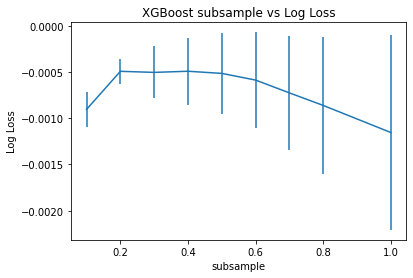

In [11]:
# plot
rcParams['figure.figsize'] = 14, 4
rcParams['font.size'] = 20
fig = plt.figure() 
ax = fig.add_subplot(111) 

pyplot.errorbar(subsample, means, yerr = stds) 
pyplot.title("XGBoost subsample vs Log Loss") 
pyplot.xlabel('subsample')
pyplot.ylabel('Log Loss')

ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.grid()
ax.minorticks_on()
ax.legend()
pyplot.show()

In [ ]:
"""
We can see that indeed 30% has the best mean performance, but we can also see that as the 
ratio increased, the variance in performance grows quite markedly. It is interesting to 
note that the mean performance of all subsample values outperforms the mean performance 
without subsampling (subsample=1.0).
"""

### Tuning column subsampling

In [ ]:
"""
We can also create a random sample of the features (or columns) to use prior to creating 
each decision tree in the boosted model. In the XGBoost wrapper for scikit-learn, this is
controlled by the colsample bytree parameter. The default value is 1.0 meaning that all 
columns are used in each decision tree. We can evaluate values for colsample bytree between
0.1 and 1.0 incrementing by 0.1
"""

In [ ]:
# grid search
model = XGBClassifier()
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(colsample_bytree=colsample_bytree)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs = -1, cv = kfold) 
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:
# plot
pyplot.errorbar(colsample_bytree, means, yerr=stds) 
pyplot.title("XGBoost colsample_bytree vs Log Loss") 
pyplot.xlabel('colsample_bytree')
pyplot.ylabel('Log Loss') 
pyplot.show()

In [ ]:
"""
Plotting the results, we can see the performance of the model plateau (at least at this scale)
with values between 0.5 to 1.0
"""

### Tuning column subsampling by split

In [ ]:
"""
Rather than subsample the columns once for each tree, we can subsample them at each split
in the decision tree. In principle, this is the approach used in random forest. We can 
set the size of the sample of columns used at each split in the colsample bylevel parameter
in the XGBoost wrapper classes for scikit-learn. As before, we will vary the ratio from 10%
to the default of 100%
"""

In [ ]:
# grid search
model = XGBClassifier()
colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(colsample_bylevel=colsample_bylevel)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs = -1, cv = kfold) 
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot
pyplot.errorbar(colsample_bylevel, means, yerr=stds) 
pyplot.title("XGBoost colsample_bylevel vs Log Loss")
pyplot.xlabel('colsample_bylevel')
pyplot.ylabel('Log Loss') 
pyplot.show()

In [ ]:
"""
Running this example prints the best configuration as well as the log loss for each tested 
configuration. We can see that the best results were achieved by setting colsample bylevel 
to 70%, resulting in an (inverted) log loss of -0.001062, which is better than -0.001239 
seen when setting the per-tree column sampling to 100%. This suggest to not give up on 
column subsampling if per-tree results suggest using 100% of columns, and to instead try
per-split column subsampling.

The results show relatively low variance and seemingly a plateau in performance after a 
value of 0.3 at this scale.
"""